In [ ]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 5, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Abdelrahman Alnajjar"
STUDENT_ID = "*******"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$68,521 per bitcoin. Since reaching it's high, the price has dropped by nearly a half. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent neural network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP/view?usp=sharing)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

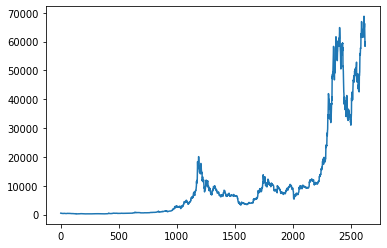

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

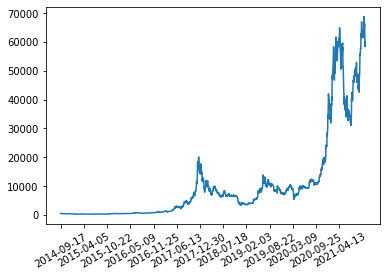

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [ ]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.
# for spliting the data to be used 
data_training = data[data['Date']< '2020-01-01'].copy()
data_test = data[data['Date']< '2020-01-01'].copy()
data_high = data_training.drop(['Date', 'Adj Close','Open','Low','Close','Volume'], axis = 1)



Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [ ]:
### YOUR CODE HERE ###
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
#data_high= data_high.reshape(-1, 1)
data_normalized = scaler.fit_transform(data_high)
data_normalized




array([[0.01290132],
       [0.01233213],
       [0.01087192],
       ...,
       [0.36736522],
       [0.36439076],
       [0.35837715]])

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [ ]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
time_steps = 60

X_train = [] 
y_train = []



# Produce your dataset based on the number of days the model could look back
for i in range(60, data_normalized.shape[0]):
 X_train.append(data_normalized[i-60:i])
 y_train.append(data_normalized[i,0])
X_train, Y_train = np.array(X_train), np.array(y_train)
X_train.shape

# or could be done using the function create_dataset

(1872, 60, 1)

### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [ ]:
### YOUR CODE HERE ###
X_test = data_test

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary:

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 60)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 1, 50)             22200     
                                                                 
 dropout_32 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_33 (LSTM)              (None, 1, 60)             26640     
                                                                 
 dropout_33 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 80)             45120     
                                                                 
 dropout_34 (Dropout)        (None, 1, 80)             0         
                                                                 
 lstm_35 (LSTM)              (None, 120)              

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mean_squared_error'])


In [ ]:

X_train = np.array(X_train)
y_train = np.array(y_train)

history= model.fit(X_train, y_train, epochs = 20, batch_size =256, validation_split=0.2)


Epoch 1/20
6/6 [==============================] - 7s 171ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 2/20
6/6 [==============================] - 0s 28ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.1252 - val_mean_squared_error: 0.1252
Epoch 3/20
6/6 [==============================] - 0s 28ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 4/20
6/6 [==============================] - 0s 31ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0836 - val_mean_squared_error: 0.0836
Epoch 5/20
6/6 [==============================] - 0s 30ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 6/20
6/6 [==============================] - 0s 27ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 7/20
6/6 [=============================

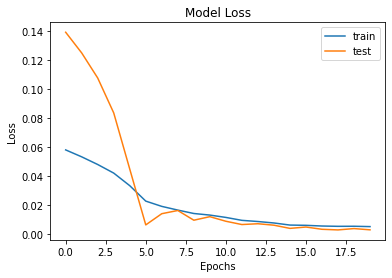

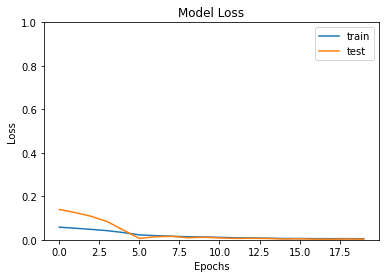

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

In [ ]:
# Build your model

### YOUR CODE HERE ###


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 60)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

model.compile(optimizer = opt, loss = loss,metrics=[metrics])





Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1, 50)             22200     
                                                                 
 dropout_36 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 1, 60)             26640     
                                                                 
 dropout_37 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_38 (LSTM)              (None, 1, 80)             45120     
                                                                 
 dropout_38 (Dropout)        (None, 1, 80)             0         
                                                                 
 lstm_39 (LSTM)              (None, 120)              

In [ ]:
batchsize = 256

epochs =  20

# Fit model
history= model.fit(X_train, y_train, epochs = epochs, batch_size =batchsize, validation_split=0.2)


Epoch 1/20
6/6 [==============================] - 6s 254ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.1390 - val_mean_squared_error: 0.1390
Epoch 2/20
6/6 [==============================] - 0s 30ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 3/20
6/6 [==============================] - 0s 33ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.1035 - val_mean_squared_error: 0.1035
Epoch 4/20
6/6 [==============================] - 0s 34ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0723 - val_mean_squared_error: 0.0723
Epoch 5/20
6/6 [==============================] - 0s 33ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 6/20
6/6 [==============================] - 0s 32ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/20
6/6 [=============================

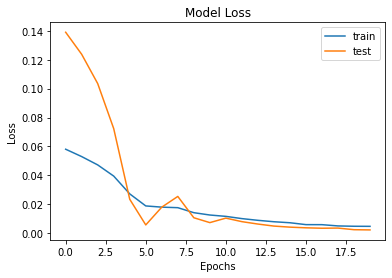

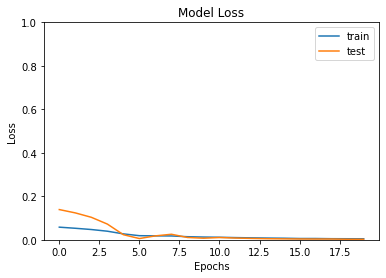

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()


### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# Build your model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential() 
model.add(LSTM(units = 512, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 60)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 256, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 128, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 1, 512)            1173504   
                                                                 
 dropout_40 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_41 (LSTM)              (None, 1, 256)            787456    
                                                                 
 dropout_41 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_42 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_42 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_43 (LSTM)              (None, 128)             

In [ ]:
batchsize = 256

epochs =  20

# Fit model
history= model.fit(X_train, y_train, epochs = epochs, batch_size =batchsize, validation_split=0.2)

Epoch 1/20
6/6 [==============================] - 7s 272ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 0.1381 - val_mean_squared_error: 0.1381
Epoch 2/20
6/6 [==============================] - 1s 126ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.1139 - val_mean_squared_error: 0.1139
Epoch 3/20
6/6 [==============================] - 1s 130ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 4/20
6/6 [==============================] - 1s 127ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/20
6/6 [==============================] - 1s 124ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 6/20
6/6 [==============================] - 1s 123ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 7/20
6/6 [========================

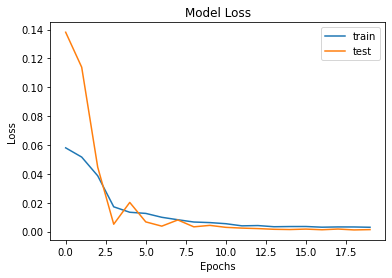

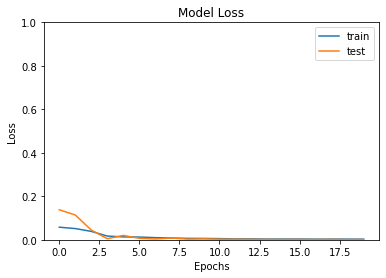

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()


### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help? Does your model use dropout or batchnormalization?

**Note:** Your model is trained on normalized data. Inorder to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

####**My Answer:** 
The asnwer will be bellow, but this is a re-implementation of the best model I tested 

In [ ]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential() 
model.add(LSTM(units = 512, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 60)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 256, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 128, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1, 512)            1173504   
                                                                 
 dropout_44 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_45 (LSTM)              (None, 1, 256)            787456    
                                                                 
 dropout_45 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_46 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_46 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_47 (LSTM)              (None, 128)             

In [ ]:
batchsize = 256

epochs =  20

# Fit model
history= model.fit(X_train, y_train, epochs = epochs, batch_size =batchsize, validation_split=0.2)

Epoch 1/20
6/6 [==============================] - 8s 302ms/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.1368 - val_mean_squared_error: 0.1368
Epoch 2/20
6/6 [==============================] - 1s 137ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.1116 - val_mean_squared_error: 0.1116
Epoch 3/20
6/6 [==============================] - 1s 144ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 4/20
6/6 [==============================] - 1s 135ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/20
6/6 [==============================] - 1s 138ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 6/20
6/6 [==============================] - 1s 141ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/20
6/6 [========================

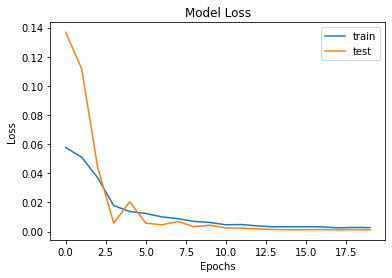

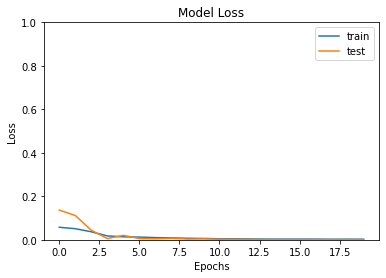

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()


####**My Answer:** 
This model gave the best predictions and least loss. I have tested many differnet models, and kept only 2 so I could compare both of them, and give the comparison\
The first model had around 180 thousand parameters and it had huge losses in comparison to the second model that had close to 2.3 million paramertes and was more complex.\
Looking at the graphs, The loss was more smoothe and lesser than the simple RNN, where in the other model, where there is the compelx RNN model, we had a smoother and lesser loss\
I have tested many optimers, and landed on 'adam', and it gave me the best resutls


## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [ ]:
# Load data

### YOUR CODE HERE ###
i=0
(X, y), (_, _) = tf.keras.datasets.reuters.load_data(
    path='reuters.npz', num_words=None, skip_top=0, maxlen=None,
    test_split=0.2, seed=113, start_char=1, oov_char=2, index_from=3
)
for i in range (10):
  print(X[i])
  print(y[i])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
[1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]
4
[1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89,

In [ ]:
max_sequence_len = 200
def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

In [ ]:
X.shape

(8982,)

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
### YOUR CODE HERE ###
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

# X_train = pad_sequences(X_train, maxlen=(max_sequence_len))



input_layer = Input(shape=(1,1))

x = Dense(1024, activation='relu')(input_layer)

x = Dense(1024, activation='relu')(x)

x = Dense(512, activation='relu')(x)

x = Dense(256, activation='relu')(x)

x = Dense(128, activation='relu')(x)

x = Dense(64, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

reuters_model = Model(input_layer, x)


loss = tf.keras.losses.BinaryCrossentropy()

opt = 'adam'

metrics = 'accuracy'

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 dense_69 (Dense)            (None, 1, 1024)           2048      
                                                                 
 dense_70 (Dense)            (None, 1, 1024)           1049600   
                                                                 
 dense_71 (Dense)            (None, 1, 512)            524800    
                                                                 
 dense_72 (Dense)            (None, 1, 256)            131328    
                                                                 
 dense_73 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_74 (Dense)            (None, 1, 64)             8256

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

reuters_model = Sequential() 
reuters_model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (1,1)))
reuters_model.add(Dropout(0.2)) 
reuters_model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.3)) 
reuters_model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.4)) 
reuters_model.add(LSTM(units = 120, activation = 'relu'))
reuters_model.add(Dropout(0.5)) 
reuters_model.add(Dense(units =1))
reuters_model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

reuters_model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 1, 50)             10400     
                                                                 
 dropout_80 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_82 (LSTM)              (None, 1, 60)             26640     
                                                                 
 dropout_81 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_83 (LSTM)              (None, 1, 80)             45120     
                                                                 
 dropout_82 (Dropout)        (None, 1, 80)             0         
                                                                 
 lstm_84 (LSTM)              (None, 120)             

In [ ]:
batchsize = 256
epochs =  20

import numpy as np

X_train = pad_sequences(X_train, maxlen=(1))

# Fit model
history = reuters_model.fit(X_train, y_train.reshape(-1,1), batch_size=256, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
23/23 [==============================] - 6s 54ms/step - loss: 162.8436 - mean_squared_error: 162.8436 - val_loss: 168.0679 - val_mean_squared_error: 168.0679
Epoch 2/10
23/23 [==============================] - 1s 24ms/step - loss: 144.1819 - mean_squared_error: 144.1819 - val_loss: 89.7512 - val_mean_squared_error: 89.7512
Epoch 3/10
23/23 [==============================] - 1s 23ms/step - loss: 99.8748 - mean_squared_error: 99.8748 - val_loss: 91.3846 - val_mean_squared_error: 91.3846
Epoch 4/10
23/23 [==============================] - 1s 24ms/step - loss: 96.8945 - mean_squared_error: 96.8945 - val_loss: 95.7416 - val_mean_squared_error: 95.7416
Epoch 5/10
23/23 [==============================] - 1s 23ms/step - loss: 95.6827 - mean_squared_error: 95.6827 - val_loss: 93.8317 - val_mean_squared_error: 93.8317
Epoch 6/10
23/23 [==============================] - 1s 24ms/step - loss: 92.4425 - mean_squared_error: 92.4425 - val_loss: 91.1626 - val_mean_squared_error: 91.1626
Epoc

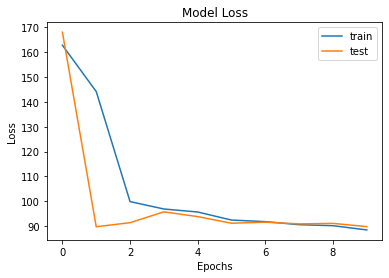

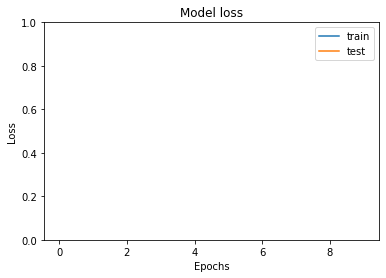

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###



model = Sequential() 
model.add(LSTM(units = 512, activation = 'relu', return_sequences = True, input_shape = (1,1)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 256, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 128, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 1, 512)            1052672   
                                                                 
 dropout_92 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_94 (LSTM)              (None, 1, 256)            787456    
                                                                 
 dropout_93 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_95 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_94 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_96 (LSTM)              (None, 128)             

In [ ]:
batchsize = 256
epochs =  20

import numpy as np

X_train = pad_sequences(X_train, maxlen=(1))

# Fit model
history = model.fit(X_train, y_train.reshape(-1,1), batch_size=256, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
23/23 [==============================] - 9s 140ms/step - loss: 152.5226 - mean_squared_error: 152.5226 - val_loss: 91.1188 - val_mean_squared_error: 91.1188
Epoch 2/10
23/23 [==============================] - 3s 109ms/step - loss: 96.8260 - mean_squared_error: 96.8260 - val_loss: 92.1052 - val_mean_squared_error: 92.1052
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 89.6411 - mean_squared_error: 89.6411 - val_loss: 91.0372 - val_mean_squared_error: 91.0372
Epoch 4/10
23/23 [==============================] - 2s 108ms/step - loss: 89.4667 - mean_squared_error: 89.4667 - val_loss: 90.2071 - val_mean_squared_error: 90.2071
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 88.9432 - mean_squared_error: 88.9432 - val_loss: 89.6608 - val_mean_squared_error: 89.6608
Epoch 6/10
23/23 [==============================] - 2s 108ms/step - loss: 88.3883 - mean_squared_error: 88.3883 - val_loss: 90.0561 - val_mean_squared_error: 90.0561
Ep

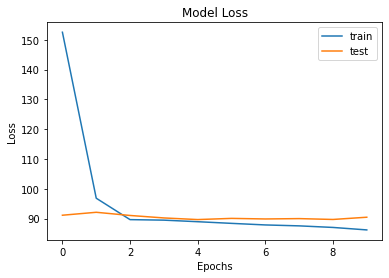

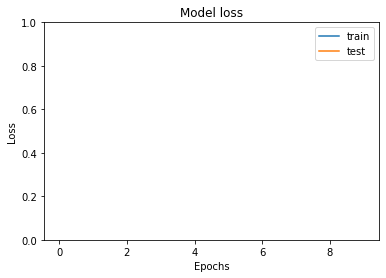

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [ ]:

input_layer = Input(shape=(1,1))

x = Dense(2048, activation='relu')(input_layer)

x = Dense(1024, activation='relu')(x)

x = Dense(512, activation='relu')(x)

x = Dense(256, activation='relu')(x)

x = Dense(128, activation='relu')(x)

x = Dense(64, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

reuters_model = Model(input_layer, x)


loss = tf.keras.losses.BinaryCrossentropy()

opt = 'adam'

metrics = 'accuracy'

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 dense_80 (Dense)            (None, 1, 2048)           4096      
                                                                 
 dense_81 (Dense)            (None, 1, 1024)           2098176   
                                                                 
 dense_82 (Dense)            (None, 1, 512)            524800    
                                                                 
 dense_83 (Dense)            (None, 1, 256)            131328    
                                                                 
 dense_84 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_85 (Dense)            (None, 1, 64)             8256

In [ ]:
reuters_model = Sequential() 
reuters_model.add(LSTM(units = 2048, activation = 'relu', return_sequences = True, input_shape = (1,1)))
reuters_model.add(Dropout(0.2)) 
reuters_model.add(LSTM(units = 1024, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.3)) 
reuters_model.add(LSTM(units = 512, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.4)) 
reuters_model.add(LSTM(units = 256, activation = 'relu'))
reuters_model.add(Dropout(0.5)) 
reuters_model.add(Dense(units =1))
reuters_model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

reuters_model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_101 (LSTM)             (None, 1, 2048)           16793600  
                                                                 
 dropout_100 (Dropout)       (None, 1, 2048)           0         
                                                                 
 lstm_102 (LSTM)             (None, 1, 1024)           12587008  
                                                                 
 dropout_101 (Dropout)       (None, 1, 1024)           0         
                                                                 
 lstm_103 (LSTM)             (None, 1, 512)            3147776   
                                                                 
 dropout_102 (Dropout)       (None, 1, 512)            0         
                                                                 
 lstm_104 (LSTM)             (None, 256)             

In [ ]:
batchsize = 256
epochs =  20

import numpy as np

X_train = pad_sequences(X_train, maxlen=(1))

# Fit model
history = reuters_model.fit(X_train, y_train.reshape(-1,1), batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/20
23/23 [==============================] - 36s 1s/step - loss: 121.5805 - mean_squared_error: 121.5805 - val_loss: 90.1956 - val_mean_squared_error: 90.1956
Epoch 2/20
23/23 [==============================] - 30s 1s/step - loss: 86.5556 - mean_squared_error: 86.5556 - val_loss: 89.7184 - val_mean_squared_error: 89.7184
Epoch 3/20
23/23 [==============================] - 30s 1s/step - loss: 85.4486 - mean_squared_error: 85.4486 - val_loss: 89.7518 - val_mean_squared_error: 89.7518
Epoch 4/20
23/23 [==============================] - 31s 1s/step - loss: 86.0943 - mean_squared_error: 86.0943 - val_loss: 90.8390 - val_mean_squared_error: 90.8390
Epoch 5/20
23/23 [==============================] - 31s 1s/step - loss: 87.0560 - mean_squared_error: 87.0560 - val_loss: 93.9376 - val_mean_squared_error: 93.9376
Epoch 6/20
23/23 [==============================] - 31s 1s/step - loss: 87.1413 - mean_squared_error: 87.1413 - val_loss: 93.2435 - val_mean_squared_error: 93.2435
Epoch 7/20
23/

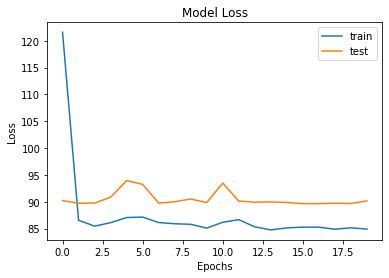

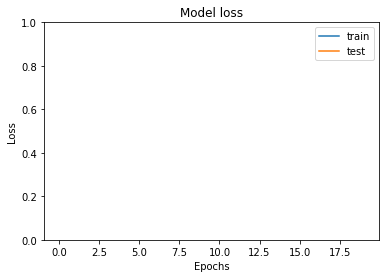

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

In [ ]:

input_layer = Input(shape=(1,1))

x = Dense(256, activation='relu')(input_layer)

x = Dense(128, activation='relu')(x)

x = Dense(64, activation='relu')(x)

x = Dense(32, activation='relu')(x)

x = Dense(16, activation='relu')(x)

x = Dense(8, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

reuters_model = Model(input_layer, x)


loss = tf.keras.losses.BinaryCrossentropy()

opt = 'adam'

metrics = 'accuracy'

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 1)]            0         
                                                                 
 dense_89 (Dense)            (None, 1, 256)            512       
                                                                 
 dense_90 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_91 (Dense)            (None, 1, 64)             8256      
                                                                 
 dense_92 (Dense)            (None, 1, 32)             2080      
                                                                 
 dense_93 (Dense)            (None, 1, 16)             528       
                                                                 
 dense_94 (Dense)            (None, 1, 8)              136 

In [ ]:
reuters_model = Sequential() 
reuters_model.add(LSTM(units = 512, activation = 'relu', return_sequences = True, input_shape = (1,1)))
reuters_model.add(Dropout(0.2)) 
reuters_model.add(LSTM(units = 256, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.3)) 
reuters_model.add(LSTM(units = 128, activation = 'relu', return_sequences = True))
reuters_model.add(Dropout(0.4)) 
reuters_model.add(LSTM(units = 64, activation = 'relu'))
reuters_model.add(Dropout(0.5)) 
reuters_model.add(Dense(units =1))
reuters_model.summary()

loss = 'mean_squared_error'

opt = 'adam'

metrics = 'mean_squared_error'

reuters_model.compile(optimizer = opt, loss = loss,metrics=[metrics])

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 1, 512)            1052672   
                                                                 
 dropout_104 (Dropout)       (None, 1, 512)            0         
                                                                 
 lstm_106 (LSTM)             (None, 1, 256)            787456    
                                                                 
 dropout_105 (Dropout)       (None, 1, 256)            0         
                                                                 
 lstm_107 (LSTM)             (None, 1, 128)            197120    
                                                                 
 dropout_106 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_108 (LSTM)             (None, 64)              

In [ ]:
batchsize = 256
epochs =  20

import numpy as np

X_train = pad_sequences(X_train, maxlen=(1))

# Fit model
history = reuters_model.fit(X_train, y_train.reshape(-1,1), batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/20
23/23 [==============================] - 9s 144ms/step - loss: 157.8860 - mean_squared_error: 157.8860 - val_loss: 112.6210 - val_mean_squared_error: 112.6210
Epoch 2/20
23/23 [==============================] - 3s 113ms/step - loss: 96.8432 - mean_squared_error: 96.8432 - val_loss: 94.9620 - val_mean_squared_error: 94.9620
Epoch 3/20
23/23 [==============================] - 3s 111ms/step - loss: 91.0634 - mean_squared_error: 91.0634 - val_loss: 89.6730 - val_mean_squared_error: 89.6730
Epoch 4/20
23/23 [==============================] - 3s 112ms/step - loss: 90.7233 - mean_squared_error: 90.7233 - val_loss: 89.6374 - val_mean_squared_error: 89.6374
Epoch 5/20
23/23 [==============================] - 3s 112ms/step - loss: 89.8600 - mean_squared_error: 89.8600 - val_loss: 90.1376 - val_mean_squared_error: 90.1376
Epoch 6/20
23/23 [==============================] - 3s 113ms/step - loss: 88.8571 - mean_squared_error: 88.8571 - val_loss: 91.0014 - val_mean_squared_error: 91.0014


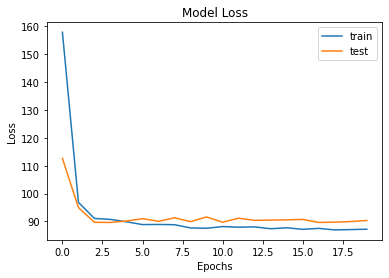

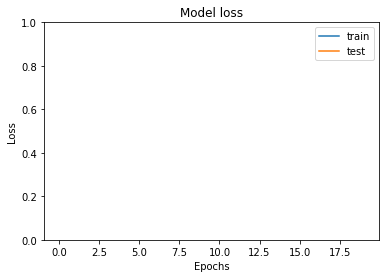

In [ ]:
# Plot the Model loss

### YOUR CODE HERE ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()